In [ ]:
pip install "gym[atari, accept-rom-license]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 22:40:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import random
import gym
import numpy as np
from PIL import Image
import torch
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pickle as pickle
import copy
import itertools

In [ ]:
hidden_layer = 200 
batch_size = 300 
learning_rate = 1e-4
gamma = 0.99 
decay_rate = 0.99 
mom_rate = 0.9
td_step = 30 
gamma_power = [gamma**i for i in range(td_step+1)]
shrink_step = True
rmsprop = True
resume = False
render = False

dim = 80 * 80 
if resume:
  model, model_target = pickle.load(open('save.ac', 'rb'))
else:
  model = {}
  model['W1_policy'] = np.random.randn(hidden_layer,dim) / np.sqrt(dim) 
  model['b1_policy'] = np.random.randn(hidden_layer) / np.sqrt(4*hidden_layer)
  model['W2_policy'] = np.random.randn(hidden_layer) / np.sqrt(hidden_layer)
  model['b2_policy'] = 0.0
  model['W1_value'] = np.random.randn(hidden_layer,dim) / np.sqrt(dim) 
  model['b1_value'] = np.random.randn(hidden_layer) / np.sqrt(4*hidden_layer)
  model['W2_value'] = np.random.randn(hidden_layer) / np.sqrt(hidden_layer)
  model['b2_value'] = 0.0
  model_target = copy.deepcopy(model)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } 
momentum = { k : np.zeros_like(v) for k,v in model.items() }
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } 

class Model():
  def __init__(self, env=None):
    super(Model, self).__init__()
  
  def sigmoid(self,x): 
    return 1.0 / (1.0 + np.exp(-x)) 

  def prepro(self,I):
    
    I = I[35:195] 
    I = I[::2,::2,0] 
    I[I == 144] = 0 
    I[I == 109] = 0 
    I[I != 0] = 1 
    return I.astype(np.float).ravel()

  def forward(self,x,modelType,model=model):
    h = np.dot(model['W1_'+modelType], x) + model['b1_'+modelType]
    h[h<0] = 0 
    out = np.dot(model['W2_'+modelType], h) + model['b2_'+modelType]
    if modelType == 'policy':
      out = self.sigmoid(out)
    return out, h

  def backward(self,eph,epx,epd,modelType):
    """ backward pass. (eph is array of intermediate hidden states) """
    db2 = sum(epd)[0]
    dW2 = np.dot(eph.T, epd).ravel()
    dh = np.outer(epd, model['W2_'+modelType])
    dh[eph <= 0] = 0 
    db1 = sum(dh)
    dW1 = np.dot(dh.T, epx)
    return {'W1_'+modelType:dW1, 'W2_'+modelType:dW2, 'b1_'+modelType:db1, 'b2_'+modelType:db2}
m=Model()
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None 
xs,h_ps,h_vs,dlogps,vs,tvs,dvs = [],[],[],[],[],[],[]
running_reward = None
reward_sum = 0
round_number = 0
total_rewards_per_episode = []
while True:
  if render: env.render()

  
  cur_x = m.prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(dim)
  prev_x = cur_x

 
  aprob, h_p = m.forward(x,'policy')
  action = 2 if np.random.uniform() < aprob else 3 

  v,h_v = m.forward(x,'value') 
  tv,_  = m.forward(x,'value',model_target)
  
  xs.append(x) 
  h_ps.append(h_p) 
  h_vs.append(h_v)
  vs.append(v)
  tvs.append(tv)
  y = 1 if action == 2 else 0 
  dlogps.append(y - aprob) 

  observation, reward, done, info = env.step(action)
  reward_sum += reward


  if reward != 0: 
    round_number += 1
    if shrink_step and round_number % 10000 == 0:
      if td_step > 15:
        td_step -= 1
    
    dvs = [0]*len(vs)
    for i in range(len(vs)):
      if len(vs) - 1 - i < td_step:
        dvs[i] = reward*(gamma_power[len(vs) - 1 - i]) - vs[i]
      else:
        dvs[i] = gamma_power[td_step]*tvs[i+td_step] - vs[i]

    
    epx = np.vstack(xs)
    eph_p = np.vstack(h_ps)
    eph_v = np.vstack(h_vs)
    epdlogp = np.vstack(dlogps)
    epv = np.vstack(dvs)
    xs,h_ps,h_vs,dlogps,vs,tvs,dvs = [],[],[],[],[],[],[] 


    #discounted_epv = epv * np.vstack([gamma**i for i in range(len(epv))])
    epdlogp *= epv 
    grad_p = m.backward(eph_p,epx,epdlogp,'policy')
    grad_v = m.backward(eph_v,epx,epv,'value')
    grad = dict(grad_p,**grad_v)

    for k in model: grad_buffer[k] += grad[k] 

    if round_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] 
        if rmsprop:
          rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
          momentum[k] = mom_rate * momentum[k] + learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        else:
          momentum[k] = mom_rate * momentum[k] + learning_rate * g
        model[k] += momentum[k]
        grad_buffer[k] = np.zeros_like(v) 

        if 'value' in k:
          model_target[k] = mom_rate * model_target[k] + (1-mom_rate) * model[k]

    print (('round %d game finished, reward: %f' % (round_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    if round_number % 3000 == 0: pickle.dump((model,model_target), open('save.ac', 'wb'))
  
  if done:
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
    total_rewards_per_episode.append(running_reward)
    print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
    
    reward_sum = 0
    observation = env.reset() 
    prev_x = None

<ipython-input-10-26b5e6f4a7eb>:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Streaming output truncated to the last 5000 lines.
round 69213 game finished, reward: -1.000000
round 69214 game finished, reward: 1.000000 !!!!!!!!
round 69215 game finished, reward: -1.000000
round 69216 game finished, reward: -1.000000
round 69217 game finished, reward: -1.000000
round 69218 game finished, reward: -1.000000
round 69219 game finished, reward: -1.000000
round 69220 game finished, reward: -1.000000
round 69221 game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -11.250381
round 69222 game finished, reward: 1.000000 !!!!!!!!
round 69223 game finished, reward: -1.000000
round 69224 game finished, reward: -1.000000
round 69225 game finished, reward: -1.000000
round 69226 game finished, reward: 1.000000 !!!!!!!!
round 69227 game finished, reward: 1.000000 !!!!!!!!
round 69228 game finished, reward: 1.000000 !!!!!!!!
round 69229 game finished, reward: 1.000000 !!!!!!!!
round 69230 game finished, reward: -1.000000
round 69231 ga

KeyboardInterrupt: ignored

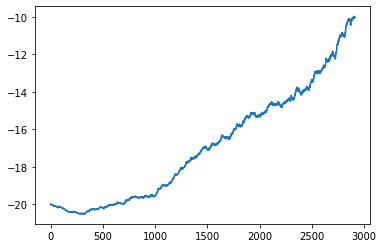

In [ ]:
plt.plot(total_rewards_per_episode)